### Libraries

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    f1_score
)
import joblib
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import average_precision_score

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
from pathlib import Path

font_path = Path.home() / "Documents" / "ST310" / "project own" / "font" / "correctfont.otf"

# Add to matplotlib's font manager
fm.fontManager.addfont(font_path)

# Get the internal font name from the file
lm_name = fm.FontProperties(fname=font_path).get_name()
print("Matplotlib registered font name:", lm_name)

# Set rcParams
mpl.rcdefaults()
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": [lm_name],
    "mathtext.fontset": "cm",
})

plt.close("all")

Matplotlib registered font name: LMRoman10


In [3]:
random_state = 42
cv_folds = 5


In [4]:
#model pipeline
def build_model_pipeline():
    """
    Create sklearn pipeline with imputation, scaling, and logistic regression.
    """
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            max_iter=1000,
            random_state=random_state,
            class_weight='balanced',  # Handle imbalanced classes
            #solver='lbfgs',
            #penalty='l2'
        ))
    ])
    return pipeline

In [5]:
#evaluate the model
def evaluate_model(model, X_test, y_test, feature_names):
    """
    Comprehensive model evaluation.
    """    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=['No default', 'Default']))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC-ROC score: {auc_roc:.4f}")


    pr_auc = average_precision_score(y_test, y_pred_proba)
    baseline = y_test.mean()
    print(f"AUC-ROC score: {auc_roc:.4f}")
    print(f"PR-AUC score: {pr_auc:.4f}")
    print(f"PR-AUC baseline (random): {baseline:.4f}")
    print(f"PR-AUC lift over random: {pr_auc / baseline:.1f}x")
    
    # Feature importance
    print("Feature importance")
    coefficients = model.named_steps['classifier'].coef_[0]
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Odds_Ratio': np.exp(coefficients),
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop 10 most important features:")
    print(importance_df.head(30).to_string(index=False))
    
    return y_pred, y_pred_proba, importance_df

In [30]:
def plot_roc_and_pr_curves(y_test, y_pred_proba):
    """
    Plot ROC curve and PR curve side by side.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'Model (AUC = {auc_roc:.4f})')
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5)')
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate (Recall)', fontsize=12)
    ax1.set_title('ROC Curve', fontsize=14)
    ax1.legend(loc='lower right')
    #ax1.grid(True, alpha=0.3)
    
    # PR Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    baseline = y_test.mean()
    
    ax2.plot(recall, precision, 'b-', linewidth=2, label=f'Model (PR-AUC = {pr_auc:.4f})')
    #ax2.axhline(y=baseline, color='r', linestyle='--', linewidth=1.5,
    #            label=f'Random Baseline ({baseline:.4f})')
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Precision-Recall Curve', fontsize=14)
    ax2.legend(loc='upper right')
    #ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 1.02])
    ax2.set_ylim([0, 1.02])
    
    plt.tight_layout()
    plt.show()
    
    print(f"ROC-AUC: {auc_roc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f} (baseline: {baseline:.4f}, lift: {pr_auc/baseline:.1f}x)")
    
    return auc_roc, pr_auc

In [34]:
def run_model(train_path, test_path, features, target_path):  ##including file names

    def train_less_features_1(X_train, y_train, pipeline):
        """
        Train model with hyperparameter tuning.
        """
        print("\n=== HYPERPARAMETER TUNING ===")
        
        param_grid = [
            
            {
            'classifier__C':  [2,5,7],  #removed 0.1 and added 5
            'classifier__penalty': ['elasticnet'],#'l1'], #elastic net proven to get best results
            'classifier__class_weight': ['balanced', {0: 1, 1: 10}],
            'classifier__l1_ratio': [0.05,0.1,0.15], ##reduced from 0.9 to the lower range
            'classifier__solver': ['saga'],
            #'classifier__max_iter': [2000],
            }
        ]
        
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv_folds,
            scoring={'roc_auc':'roc_auc',
                    'pr_auc':'average_precision',},
            refit='pr_auc',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        print(f"\nBest parameters: {grid_search.best_params_}")
        print(f"Best CV AUC-ROC: {grid_search.best_score_:.4f}")

        best_idx = grid_search.best_index_
        print(f"Best CV ROC-AUC: {grid_search.cv_results_['mean_test_roc_auc'][best_idx]:.4f}")
        
        return grid_search.best_estimator_

    train_set_path = train_path
    test_set_path = test_path

    train_set_less = pd.read_csv(train_set_path)
    test_set_less = pd.read_csv(test_set_path)

    feature_cols_all = features

    y_train= train_set_less['default_next_1y']
    X_train= train_set_less[feature_cols_all]
    y_test = test_set_less['default_next_1y']
    X_test= test_set_less[feature_cols_all]


    model = train_less_features_1(
        X_train,
        y_train,
        build_model_pipeline()
    )


    joblib.dump(
    {
        "model": model,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
    },
    target_path
    )
    
    values = {
        "model": model,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
    }
    
    variables_to_save = {'model', 'X_train', 'y_train', 'X_test', 'y_test'}
    
    results = { "model":[],"X_train": [], "y_train": [], "X_test": [], "y_test": [],}

    for variable in variables_to_save:
        results[variable].append(values[variable])

    results_df = pd.DataFrame(results)
    #results_df.to_csv(target_path, index=False)
    

    y_pred, y_pred_proba, importance_df = evaluate_model(results_df['model'][0], results_df['X_test'][0], results_df['y_test'][0], results_df['X_train'][0].columns)


    plot_roc_and_pr_curves(y_test, y_pred_proba)


In [9]:
def retrieve_results(results_path):
    results_path #= r"C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_less_3_results.joblib"
    loaded = joblib.load(results_path)

    y_pred, y_pred_proba, importance_df = evaluate_model(
        loaded["model"],
        loaded["X_test"],
        loaded["y_test"],
        loaded["X_train"].columns
    )
    plot_roc_and_pr_curves(loaded["y_test"], y_pred_proba)

Running model on the 1Y forecast full features:

['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 'cogs', 'ebit', 're', 'rect', 'invt', 'oancf', 'capx', 'fincf', 'ivncf', 'prcc_f', 'ap', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change', 'oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change', 'oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 'capex_to_as

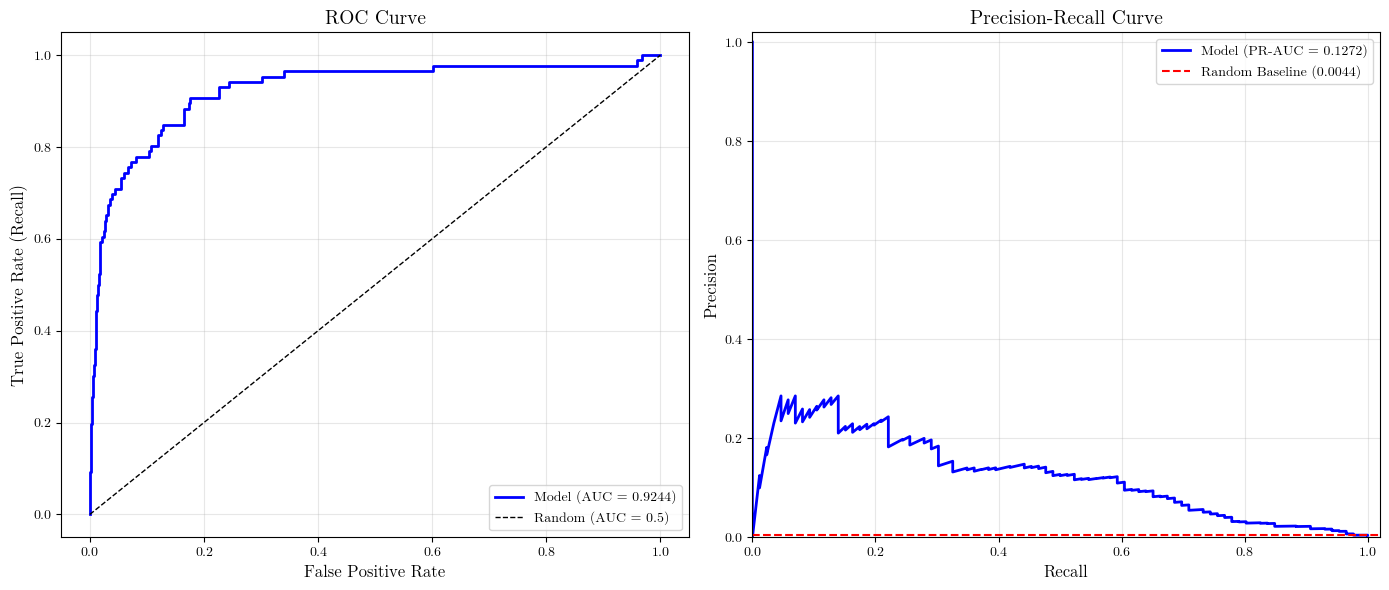

ROC-AUC: 0.9244
PR-AUC: 0.1272 (baseline: 0.0044, lift: 28.9x)


In [19]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\less_features_train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\less_features_test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path ="C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_1y_less_results_1.joblib"
features = features_all

#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

['revt', 'cogs', 'ebit', 'oibdp', 're', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'rect', 'ap', 'invt', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'oancf', 'capx', 'fincf', 'ivncf', 'dv', 'prcc_f', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'net_working_capital_to_assets', 'capex_to_assets', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'book_value_per_share', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'market_capitalization', 'free_cash_flow_to_sales', 'financing_cash_flow_to_assets', 'investing_cash_flow_to_assets', 'days_sales_outstanding', 'days_inventory_outstanding', 'days_payables_outstanding', 'cash_conversion_cycle', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'capx_1_year_pct_change'

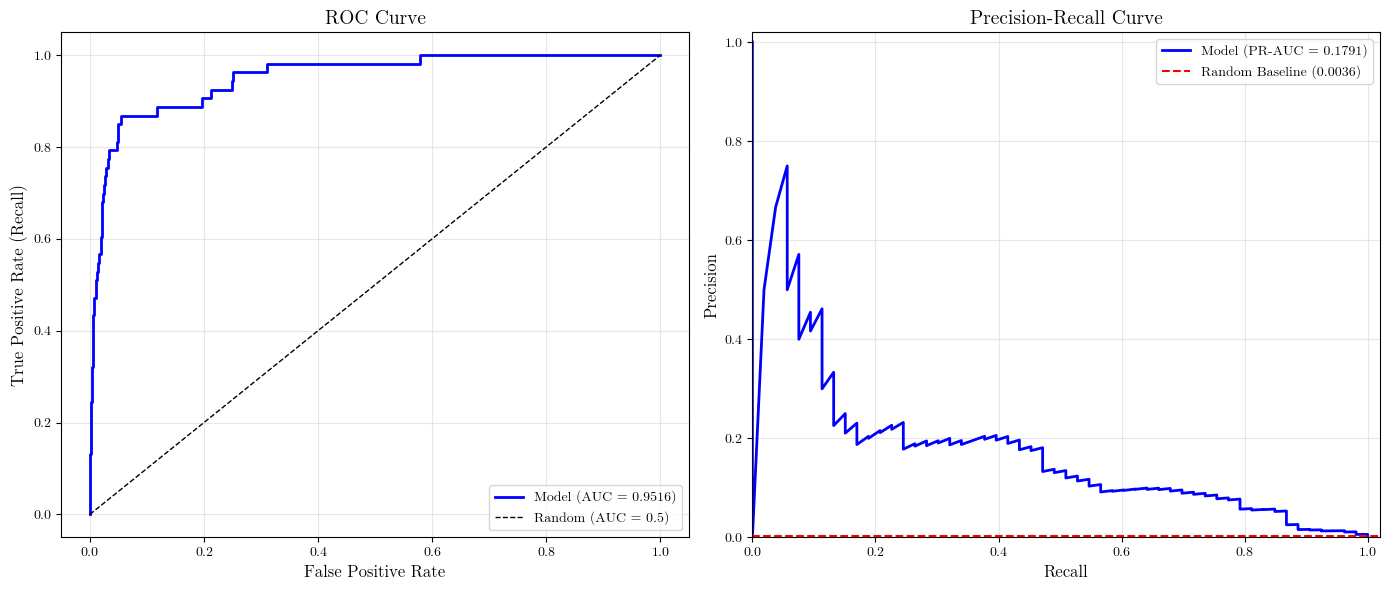

ROC-AUC: 0.9516
PR-AUC: 0.1791 (baseline: 0.0036, lift: 50.3x)


In [22]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path ="C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_1y_full_results_1.joblib"
features = features_all

#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

Full dataset performed better than the shortened one! => work on full dataset for the prediction!


['revt', 'cogs', 'ebit', 'oibdp', 're', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'rect', 'ap', 'invt', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'oancf', 'capx', 'fincf', 'ivncf', 'dv', 'prcc_f', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'net_working_capital_to_assets', 'capex_to_assets', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'book_value_per_share', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'market_capitalization', 'free_cash_flow_to_sales', 'financing_cash_flow_to_assets', 'investing_cash_flow_to_assets', 'days_sales_outstanding', 'days_inventory_outstanding', 'days_payables_outstanding', 'cash_conversion_cycle', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'capx_1_year_pct_change'

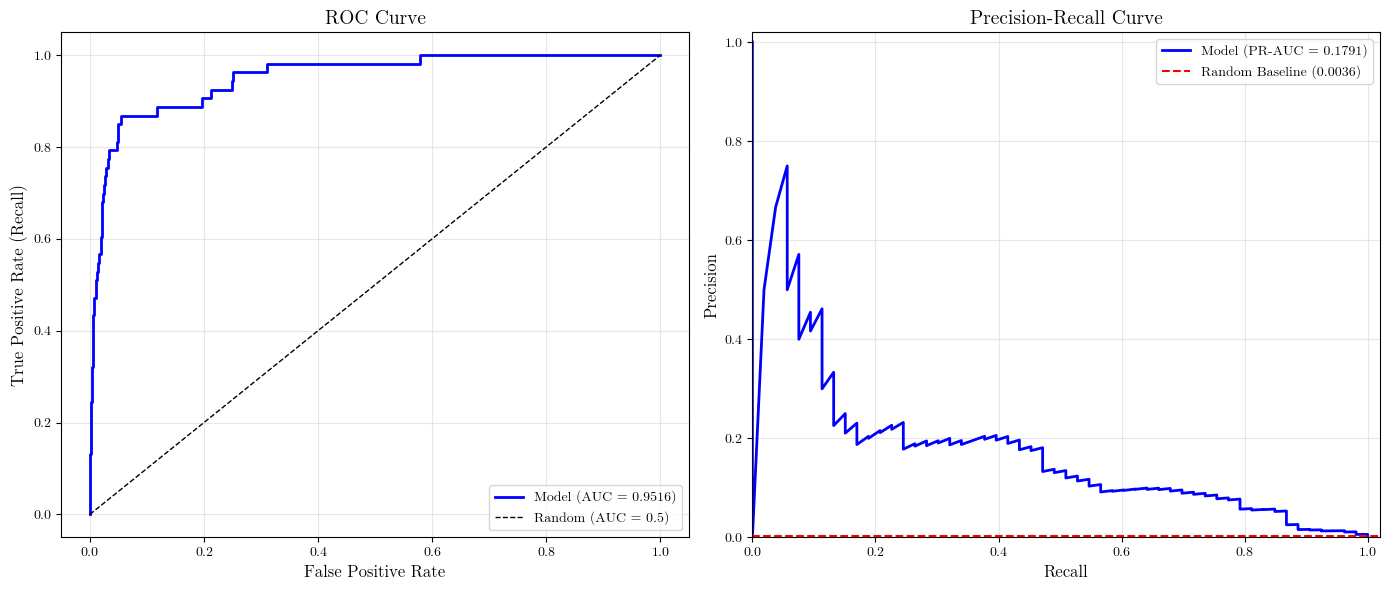

ROC-AUC: 0.9516
PR-AUC: 0.1791 (baseline: 0.0036, lift: 50.3x)


In [29]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path ="C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_1y_full_results_2.joblib"
features = features_all

#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

see if adjusting model works better

['revt', 'cogs', 'ebit', 'oibdp', 're', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'rect', 'ap', 'invt', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'oancf', 'capx', 'fincf', 'ivncf', 'dv', 'prcc_f', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'net_working_capital_to_assets', 'capex_to_assets', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'book_value_per_share', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'market_capitalization', 'free_cash_flow_to_sales', 'financing_cash_flow_to_assets', 'investing_cash_flow_to_assets', 'days_sales_outstanding', 'days_inventory_outstanding', 'days_payables_outstanding', 'cash_conversion_cycle', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'capx_1_year_pct_change'

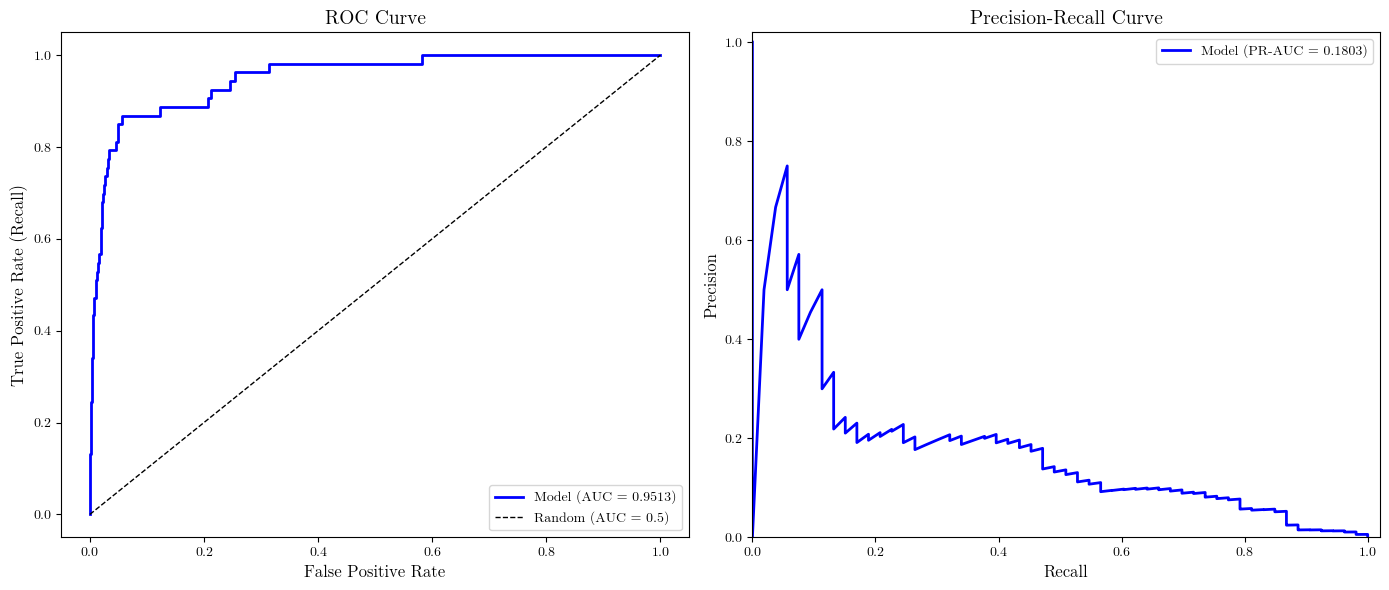

ROC-AUC: 0.9513
PR-AUC: 0.1803 (baseline: 0.0036, lift: 50.6x)


In [32]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path ="C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_1y_full_results_3.joblib"
features = features_all

#features_all

#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)



identified that better at 5, 
 'classifier__C':  [2,5,7],  #removed 0.1 and added 5 \
            'classifier__penalty': ['elasticnet'],#'l1'], #elastic net proven to get best results \
            'classifier__class_weight': ['balanced', {0: 1, 1: 10}], \
            'classifier__l1_ratio': [0.05,0.1,0.15], ##reduced from 0.9 to the lower range \
            'classifier__solver': ['saga'], \
            #'classifier__max_iter': [2000], 

In [35]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\1_y forecast\test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path ="C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_1y_full_results_4.joblib"
features = features_all

#features_all

#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

['revt', 'cogs', 'ebit', 'oibdp', 're', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'rect', 'ap', 'invt', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'oancf', 'capx', 'fincf', 'ivncf', 'dv', 'prcc_f', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'net_working_capital_to_assets', 'capex_to_assets', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'book_value_per_share', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'market_capitalization', 'free_cash_flow_to_sales', 'financing_cash_flow_to_assets', 'investing_cash_flow_to_assets', 'days_sales_outstanding', 'days_inventory_outstanding', 'days_payables_outstanding', 'cash_conversion_cycle', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'capx_1_year_pct_change'

KeyboardInterrupt: 


Classification Report:
              precision    recall  f1-score   support

  No default       1.00      0.99      1.00     19486
     Default       0.21      0.38      0.27        86

    accuracy                           0.99     19572
   macro avg       0.61      0.69      0.63     19572
weighted avg       0.99      0.99      0.99     19572


Confusion Matrix:
[[19364   122]
 [   53    33]]

AUC-ROC score: 0.9448
AUC-ROC score: 0.9448
PR-AUC score: 0.1773
PR-AUC baseline (random): 0.0044
PR-AUC lift over random: 40.4x
Feature importance

Top 10 most important features:
                Feature  Coefficient  Odds_Ratio  Abs_Coefficient
                     lt     2.576778   13.154690         2.576778
  market_capitalization    -2.359584    0.094460         2.359584
                   xint     1.559009    4.754110         1.559009
             total_debt    -1.131001    0.322710         1.131001
                     ni    -1.054387    0.348406         1.054387
                   re

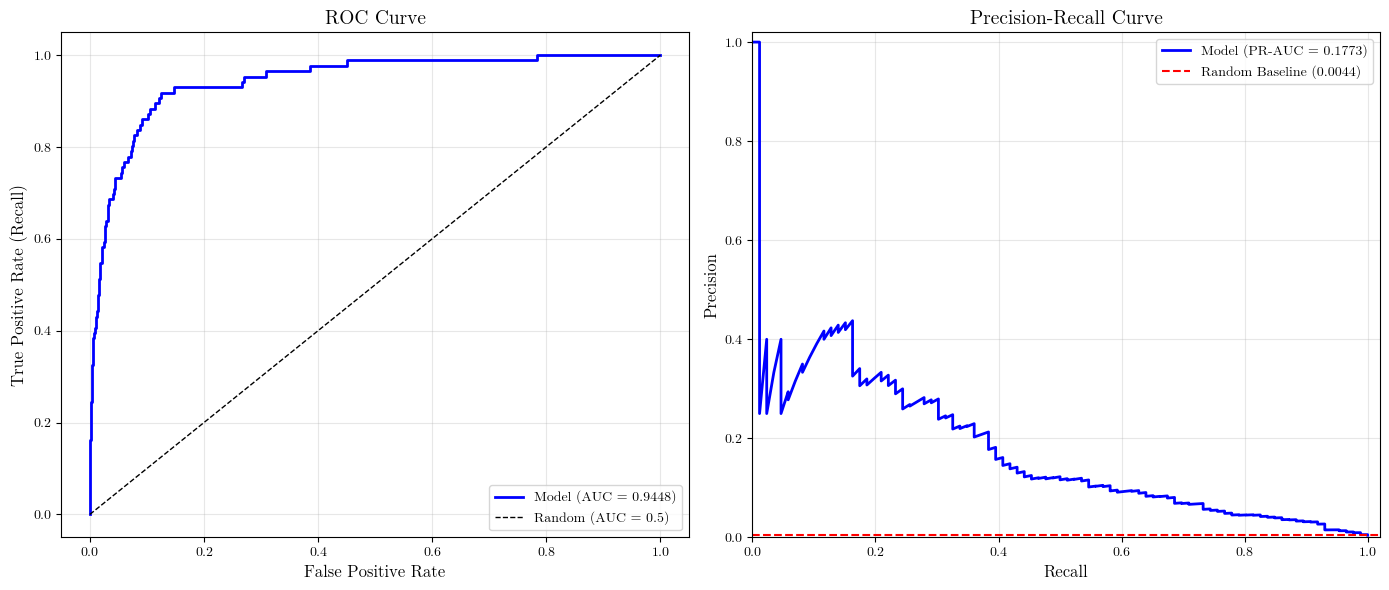

ROC-AUC: 0.9448
PR-AUC: 0.1773 (baseline: 0.0044, lift: 40.4x)


In [76]:
results_path ="C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_less_3_results.joblib"
retrieve_results(results_path)

### Train on industries

Matplotlib registered font name: LMRoman10


#### training on the capital intensive - using the less features dataset as it had slightly better performance

['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 'cogs', 'ebit', 're', 'rect', 'invt', 'oancf', 'capx', 'fincf', 'ivncf', 'prcc_f', 'ap', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change', 'oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change', 'oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 'capex_to_as

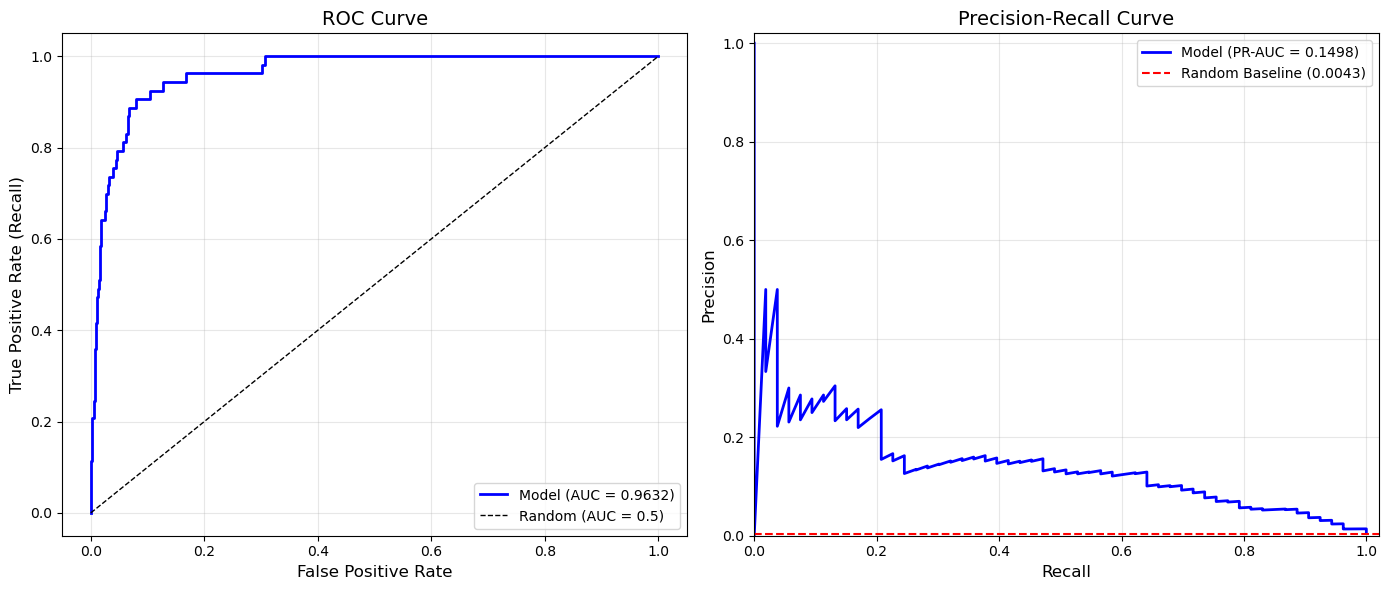

ROC-AUC: 0.9632
PR-AUC: 0.1498 (baseline: 0.0043, lift: 34.7x)


In [32]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\Capital_intensive\1y_next\Capital Intensive_less_features_train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\Capital_intensive\1y_next\Capital Intensive_less_features_test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path =r"C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_capital_1_results.csv"
features = ['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']
#["lt","market_capitalization","xint","at","revt","dltt","capx","lct","invt"] 
['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)


['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 'cogs', 'ebit', 're', 'rect', 'invt', 'oancf', 'capx', 'fincf', 'ivncf', 'prcc_f', 'ap', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change', 'oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change', 'oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 'capex_to_as

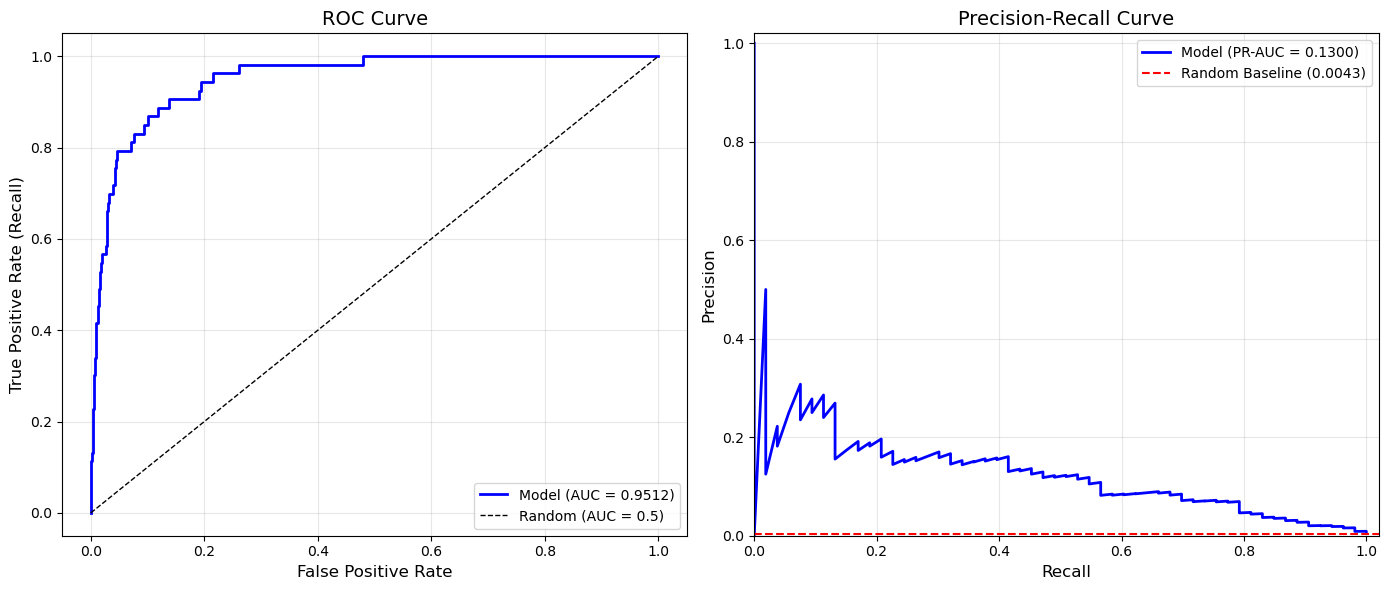

ROC-AUC: 0.9512
PR-AUC: 0.1300 (baseline: 0.0043, lift: 30.1x)


In [37]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\Capital_intensive\1y_next\Capital Intensive_less_features_train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\Capital_intensive\1y_next\Capital Intensive_less_features_test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path =r"C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_capital_2_results.csv"
features = ["lt","market_capitalization","xint","at","revt","dltt","capx","lct","invt"] 
#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']
#["lt","market_capitalization","xint","at","revt","dltt","capx","lct","invt"] 
#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

best performance ^^

['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 'cogs', 'ebit', 're', 'rect', 'invt', 'oancf', 'capx', 'fincf', 'ivncf', 'prcc_f', 'ap', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change', 'oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change', 'oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 'capex_to_as

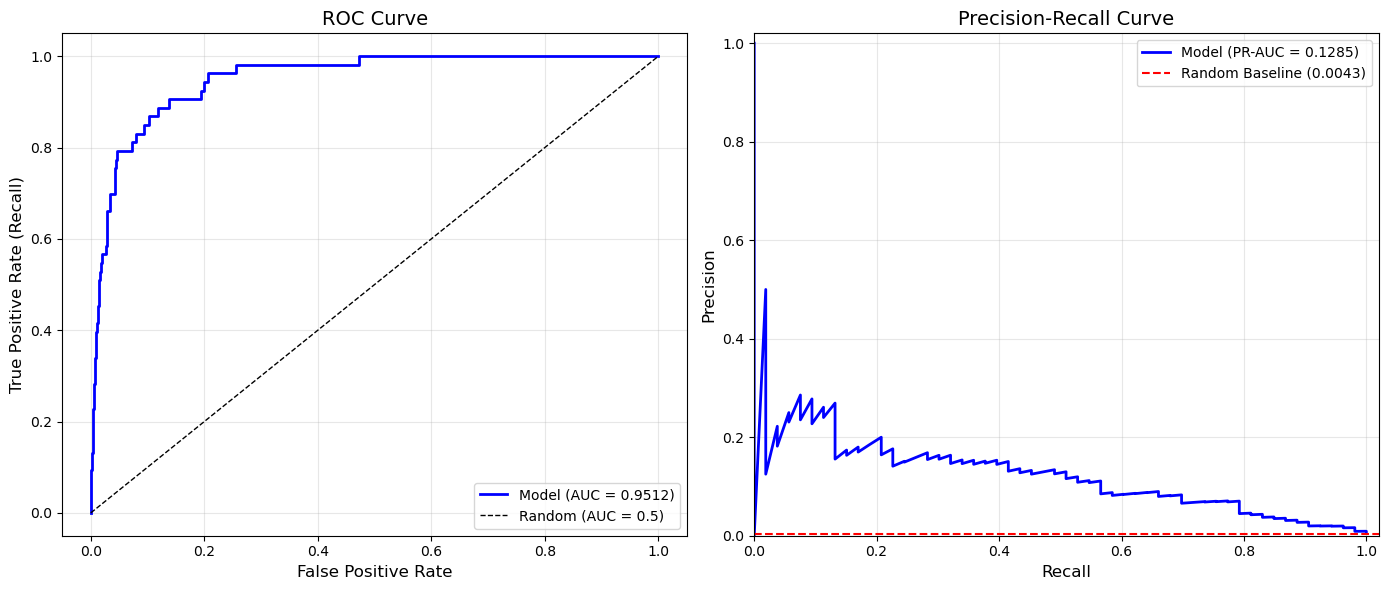

ROC-AUC: 0.9512
PR-AUC: 0.1285 (baseline: 0.0043, lift: 29.7x)


In [36]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\Capital_intensive\1y_next\Capital Intensive_less_features_train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\Capital_intensive\1y_next\Capital Intensive_less_features_test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path =r"C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_capital_1_results.csv"
features = ["lt","market_capitalization","xint","at","revt","dltt","lct","invt"] 
#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']
#["lt","market_capitalization","xint","at","revt","dltt","capx","lct","invt"] 
#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

performance drop

#### training on the food services and entertainment


['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 'cogs', 'ebit', 're', 'rect', 'invt', 'oancf', 'capx', 'fincf', 'ivncf', 'prcc_f', 'ap', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change', 'oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change', 'oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 'capex_to_as

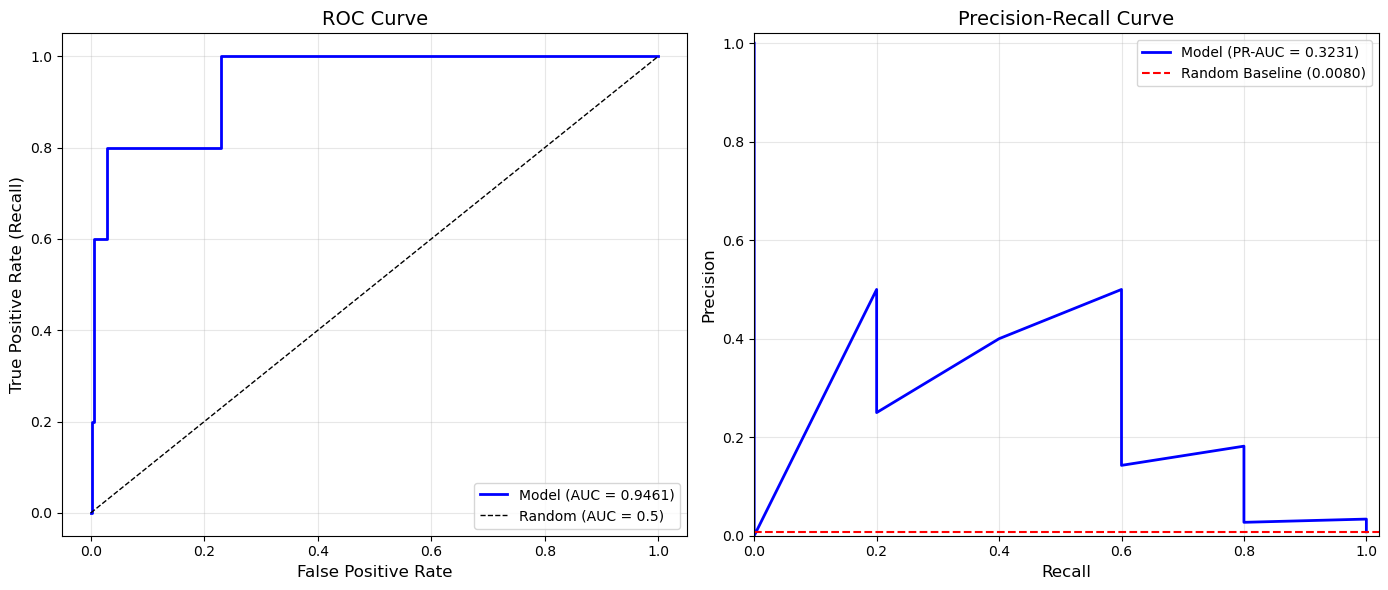

ROC-AUC: 0.9461
PR-AUC: 0.3231 (baseline: 0.0080, lift: 40.6x)


In [28]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\food services and entertainment\1y_next\food services and entertainment_less_features_train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\food services and entertainment\1y_next\food services and entertainment_less_features_test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path =r"C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_FandE_1_results.csv"
features = ['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

#### Train on trade

['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 'cogs', 'ebit', 're', 'rect', 'invt', 'oancf', 'capx', 'fincf', 'ivncf', 'prcc_f', 'ap', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change', 'oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change', 'oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 'capex_to_as

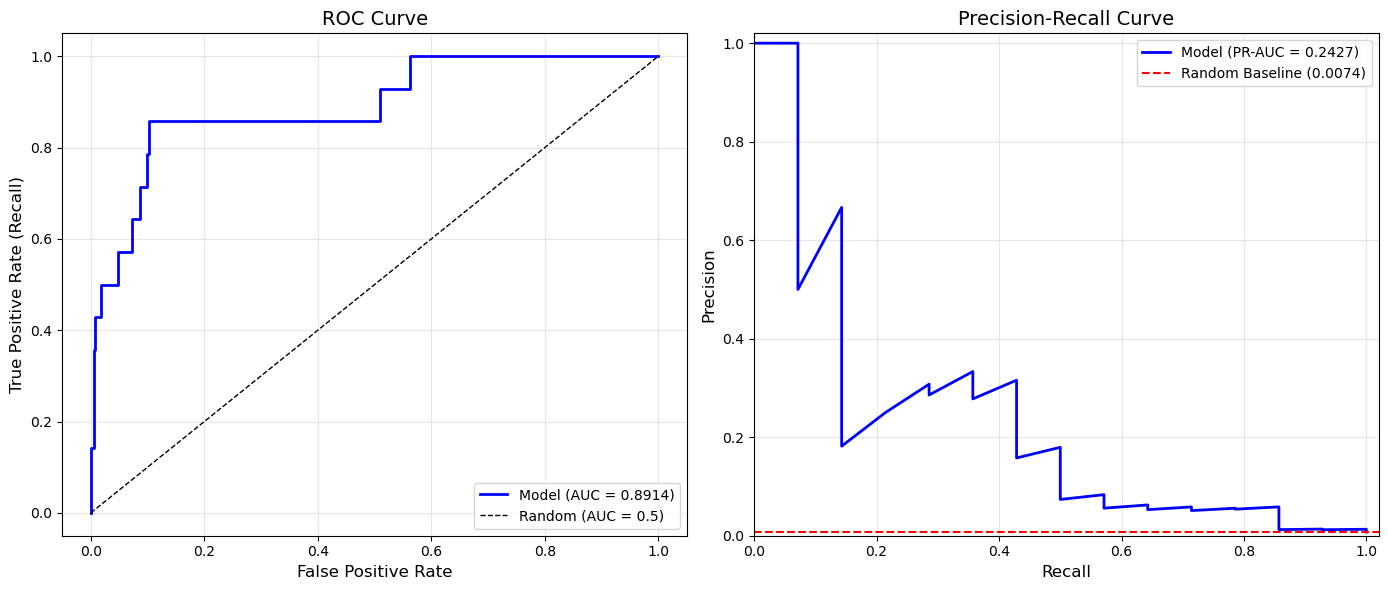

ROC-AUC: 0.8914
PR-AUC: 0.2427 (baseline: 0.0074, lift: 32.6x)


In [29]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\Trade\1y_next\Trade_less_features_train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\industries\Trade\1y_next\Trade_less_features_test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path =r"C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_trade_1_results.csv"
features = ['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

## Training on crisis periods

#### Training on crisis

['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 'cogs', 'ebit', 're', 'rect', 'invt', 'oancf', 'capx', 'fincf', 'ivncf', 'prcc_f', 'ap', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change', 'oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change', 'oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 'capex_to_as

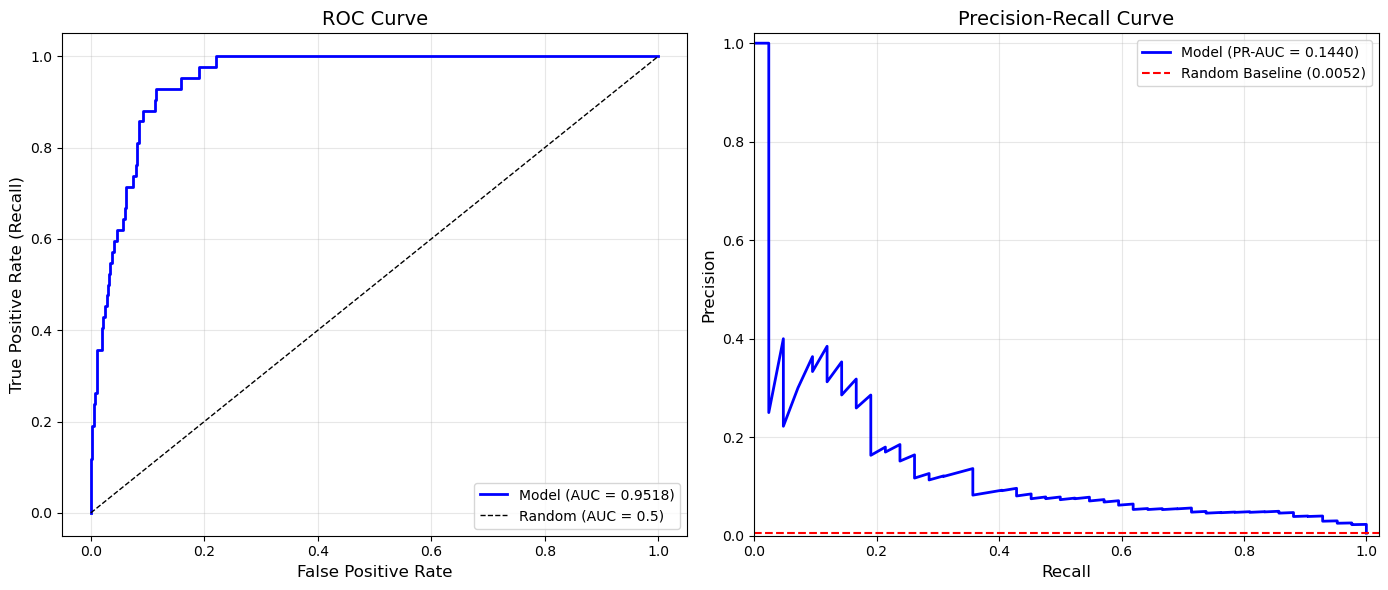

ROC-AUC: 0.9518
PR-AUC: 0.1440 (baseline: 0.0052, lift: 27.9x)


In [38]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\crises\crisis_period_less_features_train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\crises\crisis_period_less_features_test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path =r"C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_crisis_1_results.csv"
features = features_all
#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']
#["lt","market_capitalization","xint","at","revt","dltt","capx","lct","invt"] 
#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 'cogs', 'ebit', 're', 'rect', 'invt', 'oancf', 'capx', 'fincf', 'ivncf', 'prcc_f', 'ap', 'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover', 'cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio', 'total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets', 'interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio', 'revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change', 'oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change', 'revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change', 'oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change', 'oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 'capex_to_as

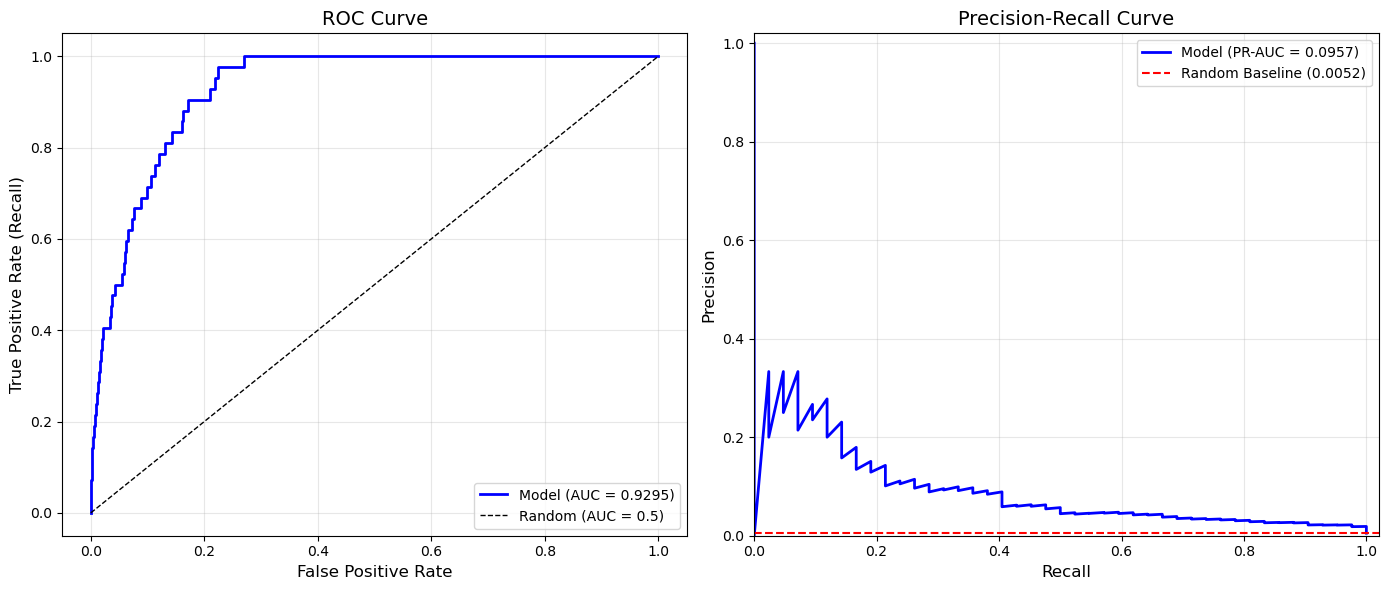

ROC-AUC: 0.9295
PR-AUC: 0.0957 (baseline: 0.0052, lift: 18.6x)


In [39]:
train_path = r"C:\Users\anaki\Documents\ST310\project own\data\crises\crisis_period_less_features_train_set_default_next_1y.csv"
test_path = r"C:\Users\anaki\Documents\ST310\project own\data\crises\crisis_period_less_features_test_set_default_next_1y.csv"
train_set = pd.read_csv(train_path)
features_all = list(train_set.columns[train_set.columns!='default_next_1y'])
print(features_all)
target_path =r"C:\\Users\\anaki\\Documents\\ST310\\project own\\data\\results\\logistic_regression_crisis_2_results.csv"
features = ['lt', 'market_capitalization', 'at', 'revt', 'xint', 'dltt', 'cogs', 'market_capitalization_2_year_pct_change', 'lct', 'capx', 'total_debt_1_year_pct_change', 'invt']
#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']
#["lt","market_capitalization","xint","at","revt","dltt","capx","lct","invt"] 
#['lt', 'at', 'market_capitalization', 'revt', 'xint', 'total_debt', 'che', 'lct', 'ni', 'dltt', 'rect', 'capx', 'dv', 'invt', 'free_cash_flow_to_sales']

run_model(train_path, test_path, features, target_path)

drop in performance!